*Authors:* Ismael Mendoza, Andrii Torchylo

The goal of this notebook is to showcase how to work with the Deblending submodule of BTK. We will go over how to create your custom deblender as well as how to efficiently use our existing deblenders.

# Setup

In [ ]:
import btk
from tqdm import tqdm
from pprint import pprint
from btk.deblend import DeblendGenerator
from btk.deblend import PeakLocalMax, SepSingleBand, SepMultiband, Scarlet

In [ ]:
catalog_name = "../data/input_catalog.fits" # contains ~85k entries
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)
LSST = btk.survey.get_surveys("LSST")

In [ ]:
# fix parameters of the generation
SEED = 1
max_n_sources = 5
batch_size = 5

# construct a sampling function 
sampling_function = btk.sampling_functions.DefaultSampling(
    max_number=max_n_sources,
    min_number=1,
    stamp_size=24.0,
    max_shift=3.0,
    min_mag = 24, 
    max_mag = 25,
    seed=SEED,
)

# creates a generator object to draw galaxies
draw_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    LSST,
    batch_size=batch_size,
    stamp_size=24.0,
    njobs=1,
    add_noise="all",
    seed=SEED,
)

# get an example batch
blend_batch = next(draw_generator)
print(blend_batch)

BlendBatch(survey_name=LSST, 
	 blend_images: np.ndarray, shape [5, 6, 120, 120]
	 isolated_images: np.ndarray, shape [5, 5, 6, 120, 120]
	 catalog_list: list of <class 'astropy.table.table.Table'>, size 5
	 psfs: list of <class 'galsim.gsobject.GSObject'>, size 6
	 wcs: <class 'astropy.wcs.wcs.WCS'>)


# Internal Structure of the deblenders

All implemented deblenders follow the same template — abstract `Deblender` class. Basically, `Deblender` class standardizes inputs and outputs of the deblender, which allows to simultanously run multiple deblenders on a generated data and benchmark their performance. The `__init__` class has a required argument — `max_n_sources`, which is needed to set a fixed shape for the output of the deblender. All deblenders must implement `__deblend__` method, which performs deblending on the i-th example from the `BlendBatch`. Then we require the output to be packaged into `DeblendExample` data class, which peforms internal validation of the data format -- more on that later. The `__call__` and `batch_call` are internally implemented in the parent class, and user doesn't need to modify them to create a deblender. These two methods implement multiprocessing procedure to efficiently paralelize computation across several CPU cores. Finally `__repr__` class is used for internall bookkeeping.  

```python
class Deblender(ABC):
    """Abstract base class containing the measure class for BTK. """

    def __init__(self, max_n_sources: int) -> None:
        """Initialize the Deblender class. """
        # (Optionally) overwritten in the child class
    
    @abstractmethod
    def deblend(self, ii: int, blend_batch: BlendBatch) -> DeblendExample:
        """Runs the deblender on the ii-th example of a given batch."""
        # Must be overritten in the child class

    def __call__(self, blend_batch: BlendBatch, njobs: int = 1, **kwargs) -> DeblendBatch:
        """Calls the (user-implemented) `deblend` method along with validation of the input."""

    def batch_call(self, blend_batch: BlendBatch, njobs: int = 1, **kwargs) -> DeblendBatch:
        """Implements multiprocessing call of a measure function on the entire batch."""
    
    @classmethod
    def __repr__(cls):
        """Returns the name of the class for bookkeeping."""
        return cls.__name__
```

## Creating Your Own Deblender

Let's walk through teh process of creating your own Deblender. We will use `PeakLocalMax` which BTK implements as an example. To start of we need to create a subclass of the `Deblender` class:

```python
class PeakLocalMax(Deblender):
    """This class detects centroids with `skimage.feature.peak_local_max`."""
```
As the comment suggests we will be using a function `skimage.feature.peak_local_max` to perform galaxy detection. By default, this fucniton works on a grayscale image, but in the blend batch we have access to multiple filter. Thus, we will let the user either use a particular filter by specifiyng the index of the band (i.e. `use_band=3`) or average across the filters if `use_mean=True` is turned on. Additionally, we save the parameters such as `sky_level`, `threshold_scale`, and `min_distance` to filter out noisy detections.  Here are the details of the `__init__` class:

```python
def __init__(
    self,
    max_n_sources: int,
    sky_level: float,
    threshold_scale: int = 5,
    min_distance: int = 2,
    use_mean: bool = False,
    use_band: Optional[int] = None,
) -> None:
    """Initializes Deblender class. Exactly one of 'use_mean' or 'use_band' must be specified.

    Args:
        max_n_sources: See parent class.
        sky_level: Background intensity in images to be detected (assumed constant).
        threshold_scale: Minimum number of sigmas above noise level for detections.
        min_distance: Minimum distance in pixels between two peaks.
        use_mean: Flag to use the band average for deblending.
        use_band: Integer index of the band to use for deblending
    """
    super().__init__(max_n_sources)
    self.min_distance = min_distance
    self.threshold_scale = threshold_scale
    self.sky_level = sky_level

    if use_band is None and not use_mean:
        raise ValueError("Either set 'use_mean=True' OR indicate a 'use_band' index")
    if use_band is not None and use_mean:
        raise ValueError("Only one of the parameters 'use_band' and 'use_mean' has to be set")
    self.use_mean = use_mean
    self.use_band = use_band
```

Now comes the crucial step —- implementing `deblend` method.  The first step of any `deblend` method is to index into the `BlendBatch` and slect the data that corresponds to the i-th example. In this case, we just need the `blend_image`. Once we selected the target grayscale image (either by averaging or by fixing a band) we run `peak_local_max` on the image. Notice that the output coordinates will be in the pixel values, but the requirement for the BTK is to convert output coordinates to `ra` and `dec`, and wrap the detection in `atropy.Table`. Finally we package the output into an object called `DeblendExample` that conevniently stores our data. 

```python
def deblend(self, ii: int, blend_batch: BlendBatch) -> DeblendExample:
    """Performs deblending on the ii-th example from the batch."""
    blend_image = blend_batch.blend_images[ii]
    image = np.mean(blend_image, axis=0) if self.use_mean else blend_image[self.use_band]

    # compute threshold value
    threshold = self.threshold_scale * np.sqrt(self.sky_level)

    # calculate coordinates
    coordinates = peak_local_max(
        image,
        min_distance=self.min_distance,
        threshold_abs=threshold,
        num_peaks=self.max_n_sources,
    )
    x, y = coordinates[:, 1], coordinates[:, 0]

    # convert coordinates to ra, dec
    wcs = blend_batch.wcs
    ra, dec = wcs.pixel_to_world_values(x, y)
    ra *= 3600
    dec *= 3600

    # wrap in catalog
    catalog = Table()
    catalog["ra"], catalog["dec"] = ra, dec
    catalog["x_peak"], catalog["y_peak"] = x, y

    if len(catalog) > self.max_n_sources:
        raise ValueError(
            "`PeakLocalMax` detected more sources than `max_n_sources`. Consider increasing"
            "`threshold_scale` or `max_n_sources`."
        )

    return DeblendExample(self.max_n_sources, catalog)
```

# Deblend Example 

BTK supports three kinds of blending realated tasks —— **detection**, **segmentation**, and **deblending** of individual sources. Data for all of these tasks can be stored in the `DeblendingExample`. Specifically, we **require** the user to pass catalog with detections, while **segmentation** and **deblended_images** are optional. This is done because **detetcion** is crucial for doing any other task like (segmentation and deblending), and also we use detections to match the output of the deblender to the ground truth of generated data. 

```python
class DeblendExample:
    """Class that validates the deblending results for a single blend."""

    max_n_sources: int
    catalog: Table
    n_bands: Optional[int] = None
    image_size: Optional[int] = None
    segmentation: Optional[np.ndarray] = None
    deblended_images: Optional[np.ndarray] = None
    extra_data: Optional[dict] = None
```


The create an instance of the `DeblendExample` we need some of the following parameters:
- `max_n_sources` — maximum number of galaxies on the stamp set in the generator. This should be the same across all examples. 
- `n_bands` - number of image channels (filters) needed for internal validation
- `image_size` -- size of the image needed for internal validation
- `catalog` - astropy table that must contain `ra` and `dec` columns with the coordinates of the detected galaxies (see example above)
- `segmentation` - `np.array` of shape `[self.max_n_sources, self.image_size, self.image_size]` with values 1 if pixel belongs to the ith galaxy and 0 otherwise
- `deblended_images` - `np.array` of shape `[self.max_n_sources, self.n_bands, self.image_size, self.image_size]` where `deblended_images[i]` is the ith deblended image. If detected less than `self.max_n_sources` remaining images should be zeros. 

## Running Deblenders
Let's test the output of the `PeakLocalMax` on an example batch

In [ ]:
PLM = PeakLocalMax(max_n_sources, use_mean=True) 
deblend_example = PLM.deblend(3, blend_batch) # 3rd example from the batch
print(deblend_example)


DeblendExample(max_n_sources = 5, n_bands = None, image_size = None), 
 containing: 
	catalog: <class 'astropy.table.table.Table'>
	segmentation: None
	deblended_images: None


Segmentation, and deblended images are None because our deblenders only does the detection. Let's look at the detected coordiantes. Technically, we require only `ra` and `dec` to be saved, but saving `x_peak` and `y_peak` can be useful for visualization purposes.

In [ ]:
print(deblend_example.catalog)

        ra                dec         x_peak y_peak
------------------ ------------------ ------ ------
0.6999999999877023 0.6999999999963016     63     63
1295997.7000000002 1.8999999997994146     48     69


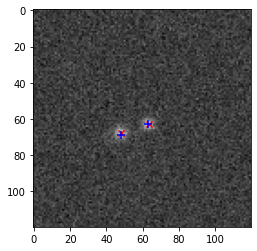

In [ ]:
import matplotlib.pyplot as plt

# plot the first blend in the batch, with the r-band
plt.imshow(blend_batch.blend_images[3, 2, :, :], cmap="gray")

# plot centers of truth
plt.scatter(blend_batch.catalog_list[3]["x_peak"], blend_batch.catalog_list[3]["y_peak"], c="r", marker="x")

# plot centers of prediction
x, y = deblend_example.catalog['x_peak'], deblend_example.catalog['y_peak']
plt.scatter(x, y, c="b", marker="+", s=50)

Now suppose we want to efficeintly run our deblender on the entire batch. We can do so by calling the following command:

In [ ]:
deblend_batch = PLM(blend_batch, njobs=1) # deblend the whole batch
print(deblend_batch)

DeblendBatch(batch_size = 5, max_n_sources = 5 n_bands = None, image_size = 120), containing: 
	catalog_list: list of <class 'astropy.table.table.Table'>, size 5
	segmentation: None
	deblended_images: None


Finally if we want to collect more statistics about the performace of our deblender, we can run our deblender on many batches using `DeblendGenerator`. We will also compute recall of our algorithm.

In [ ]:
from btk.metrics.detection import Recall
from btk.match import PixelHungarianMatcher
matcher = PixelHungarianMatcher(pixel_max_sep=5.0) # maximum separation to consider match, in pixels


In [ ]:
deblend_generator = DeblendGenerator(PLM, draw_generator, njobs=1)
recall = Recall(batch_size)

n_batches = 10
for n in tqdm(range(n_batches)):
    blend_batch = next(draw_generator)
    deblend_batch = PLM(blend_batch, njobs=1)
    true_catalog_list = blend_batch.catalog_list
    pred_catalog_list = deblend_batch.catalog_list
    matching = matcher(true_catalog_list, pred_catalog_list)
    recall(matching.tp, matching.n_true, matching.n_pred) # accumulate values internally

100%|██████████| 10/10 [00:01<00:00,  7.63it/s]


In [ ]:
recall.aggregate()

0.839871723993241

# Segmentation and Deblending 

As another example we can look at the `SepSingleBand` deblender in BTK. This deblender uses SourceExtractor to perform all three tasks — detection, segmentation, and deblending. 

In [ ]:
SEP = SepSingleBand(max_n_sources, use_mean=True) # use_band=2)
deblend_example = SEP.deblend(1, blend_batch) # 2nd example from the batch
print(deblend_example)

DeblendExample(max_n_sources = 5, n_bands = 1, image_size = 120), 
 containing: 
	catalog: <class 'astropy.table.table.Table'>
	segmentation: <class 'numpy.ndarray'>, shape [5, 120, 120]
	deblended_images: <class 'numpy.ndarray'>, shape [5, 1, 120, 120]


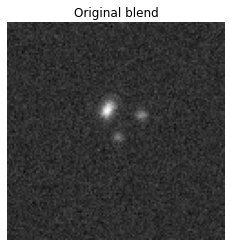

In [ ]:
import matplotlib.pyplot as plt

# plot the first blend in the batch, with the r-band
plt.imshow(blend_batch.blend_images[1, 2, :, :], cmap="gray")
plt.axis('off')
plt.title('Original blend')
plt.show()

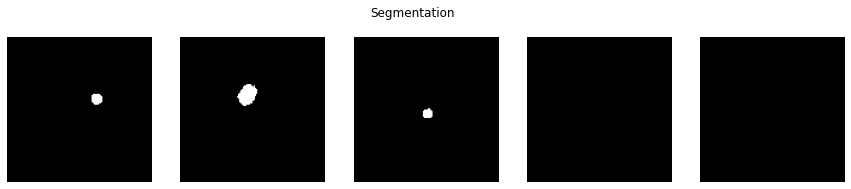

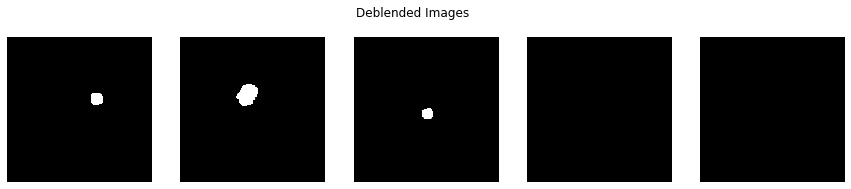

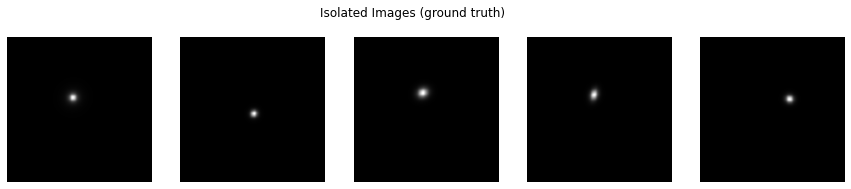

In [ ]:
# use global vmin and vmax
vmin = 0
vmax = 1

fig, ax = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle("Segmentation")
for i in range(5):
    ax[i].imshow(deblend_example.segmentation[i],cmap="gray", vmin=vmin, vmax=vmax)
    ax[i].axis('off')

fig, ax = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle("Deblended Images")
for i in range(5):
    ax[i].imshow(deblend_example.deblended_images[i][0], cmap="gray", vmin=vmin, vmax=vmax)
    ax[i].axis('off')

fig, ax = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle("Isolated Images (ground truth)")
for i in range(5):
    # blend 1, isolated image i, channel 2
    ax[i].imshow(blend_batch.isolated_images[1, i, 2, :, :],cmap="gray")
    ax[i].axis('off')

# Running multiple deblenders 

Now if we would like to benchmark performance of multiple deblenders against each other, we can just pass a list of deblenders to `DeblendGenerator`, which will keep track of all bookkeeping for us. Let's see which of our deblnenders has the best recall. 

In [ ]:
PLM = PeakLocalMax(max_n_sources, use_mean=True) # use_band=2)
SEP = SepSingleBand(max_n_sources, use_mean=True) # use_band=2)
SCARLET = Scarlet(max_n_sources)

deblenders = [PLM, SEP, SCARLET]

In [ ]:
deblend_generator = DeblendGenerator(deblenders, draw_generator, njobs=4)
blend_batch, deblend_batch = next(deblend_generator)
pprint(deblend_batch)

{'PeakLocalMax': DeblendBatch(batch_size = 5, max_n_sources = 5 n_bands = None, image_size = 120), containing: 
	catalog_list: list of <class 'astropy.table.table.Table'>, size 5
	segmentation: None
	deblended_images: None,
 'Scarlet': DeblendBatch(batch_size = 5, max_n_sources = 5 n_bands = 6, image_size = 120), containing: 
	catalog_list: list of <class 'astropy.table.table.Table'>, size 5
	segmentation: None
	deblended_images: <class 'numpy.ndarray'>, shape [5, 5, 6, 120, 120],
 'SepSingleBand': DeblendBatch(batch_size = 5, max_n_sources = 5 n_bands = 1, image_size = 120), containing: 
	catalog_list: list of <class 'astropy.table.table.Table'>, size 5
	segmentation: <class 'numpy.ndarray'>, shape [5, 5, 120, 120]
	deblended_images: <class 'numpy.ndarray'>, shape [5, 5, 1, 120, 120]}


As we can see the output just becomes a dictionary where keys are deblenders and values are corresponding DeblendingBatches. Let's see the results:

In [ ]:
deblend_generator = DeblendGenerator(PLM, draw_generator, njobs=1)
recall = Recall(batch_size)
results = {}

for name, value in deblend_batch.items():
    true_catalog_list = blend_batch.catalog_list
    pred_catalog_list = value.catalog_list
    matching = matcher(true_catalog_list, pred_catalog_list)
    results[name] = recall(matching.tp, matching.n_true, matching.n_pred)

pprint(results)

{'PeakLocalMax': 0.9166666666666666,
 'Scarlet': 1.0,
 'SepSingleBand': 0.8333333333333334}
